In [ ]:
# https://www.kaggle.com/code/purplejester/pytorch-deep-time-series-classification/notebook
# https://www.kaggle.com/code/polomarco/ecg-classification-cnn-lstm-attention-mechanism

# https://github.com/TheMrGhostman/InceptionTime-Pytorch/blob/master/InceptionTime%20evaluation.ipynb

In [1]:
import numpy as np
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler

import shap

from math import ceil
import statistics
import pickle

from dtaidistance import dtw
from tslearn.barycenters import dtw_barycenter_averaging
import random


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


In [2]:
print(shap.__version__)

0.41.0


In [2]:
! nvidia-smi

Mon Apr  3 10:31:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:01:00.0 Off |                  Off |
| 33%   37C    P8     4W / 260W |     15MiB / 24217MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ! kill -9 1243300
# torch.cuda.empty_cache()

In [ ]:
print(sys.path)

In [3]:
! ls /home/mmozolewski/notebooks/InceptionTime-Pytorch
DATA_DIRECTORY = '/home/mmozolewski/notebooks/InceptionTime-Pytorch/data'
MODEL_DIRECTORY = '/home/mmozolewski/notebooks/InceptionTime-Pytorch'
CLASSFIER_MODEL_PATH = f'{MODEL_DIRECTORY}/inception_time_my_model.pth'

 data
 inception.py
'InceptionTime evaluation.ipynb'
'InceptionTime_full-version_lr-{5e-3,1e-3,2e-4},_bs-512_ks-[5,11,23]_100-epochs_state_dict.pt'
 inception_time_my_model.pth
 __pycache__
 README.md


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"
print(DEVICE)

cuda


In [5]:
import sys
sys.path.append('/home/mmozolewski/notebooks/InceptionTime-Pytorch')

from inception import Inception, InceptionBlock

# Data

In [6]:
X = np.vstack((np.load(f"{DATA_DIRECTORY}/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load(f"{DATA_DIRECTORY}/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load(f"{DATA_DIRECTORY}/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

X.shape


(83680, 160)

In [28]:
pd.DataFrame(y).value_counts()

1.0    52244
0.0    21173
3.0     7804
2.0     2459
dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"train= {len(X_train)}, test= {len(X_test)}")

train= 66944, test= 16736


# original model

In [175]:
class Flatten(nn.Module):
  def __init__(self, out_features):
    super(Flatten, self).__init__()
    self.output_dim = out_features

  def forward(self, x):
    return x.view(-1, self.output_dim)

class Reshape(nn.Module):
  def __init__(self, out_shape):
    super(Reshape, self).__init__()
    self.out_shape = out_shape

  def forward(self, x):
    return x.view(-1, *self.out_shape)


inception_time_original_model = nn.Sequential(
                    Reshape(out_shape=(1,160)),
                    InceptionBlock(
                        in_channels=1,
                        n_filters=32,
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4,
                        n_filters=32,
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=4)
        )

inception_time_original_model.load_state_dict(torch.load(
  MODEL_DIRECTORY + "/InceptionTime_full-version_lr-{5e-3,1e-3,2e-4},_bs-512_ks-[5,11,23]_100-epochs_state_dict.pt"))
inception_time_original_model


Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (conv_from_bottleneck_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(1, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_siz

In [176]:
inception_time_original_model = inception_time_original_model.to(DEVICE)
next(inception_time_original_model.parameters()).is_cuda # returns a boolean

True

## Scores

In [10]:
# X_test_torch = torch.from_numpy(X_test)
X_test_tensor_on_device = torch.tensor(X_test).float().to(device=DEVICE)

In [11]:
inception_time_original_model.eval()
with torch.no_grad():
    x_pred = np.argmax(inception_time_original_model(X_test_tensor_on_device).detach().cpu(), axis=1)
x_pred

tensor([1, 1, 1,  ..., 3, 1, 0])

In [12]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.9125625555928921

In [15]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.9493307839388145

In [16]:
cf1 = confusion_matrix(y_true=y_test, y_pred=x_pred) # x_axis = predicted, y_axis = ground_truth
cf1

array([[ 3805,   296,    27,   107],
       [   91, 10307,     8,    39],
       [   22,     8,   425,    24],
       [  169,    37,    20,  1351]])

# Visualisation

In [12]:
import seaborn as sns
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8


In [13]:
def plot_time_series_with_sd(data_df, class_name, ax, n_steps=10, roll=False):
  time_series_df_mean = pd.DataFrame(data_df.mean(axis=0).to_numpy())
  time_series_df_std = pd.DataFrame(data_df.std(axis=0).to_numpy())
  if roll:
    smooth_path = time_series_df_mean.rolling(n_steps).mean()
    path_deviation = 1 * time_series_df_std.rolling(n_steps).mean()
  else:
    smooth_path = time_series_df_mean
    path_deviation = 1 * time_series_df_std


  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [56]:
df = pd.DataFrame(X)
df['target'] = y
df['target'] = df['target'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83680 entries, 0 to 83679
Columns: 161 entries, 0 to target
dtypes: float64(160), int32(1)
memory usage: 102.5 MB


In [59]:
classes = df['target'].unique()
print(classes)
class_names = classes

[1 0 2 3]


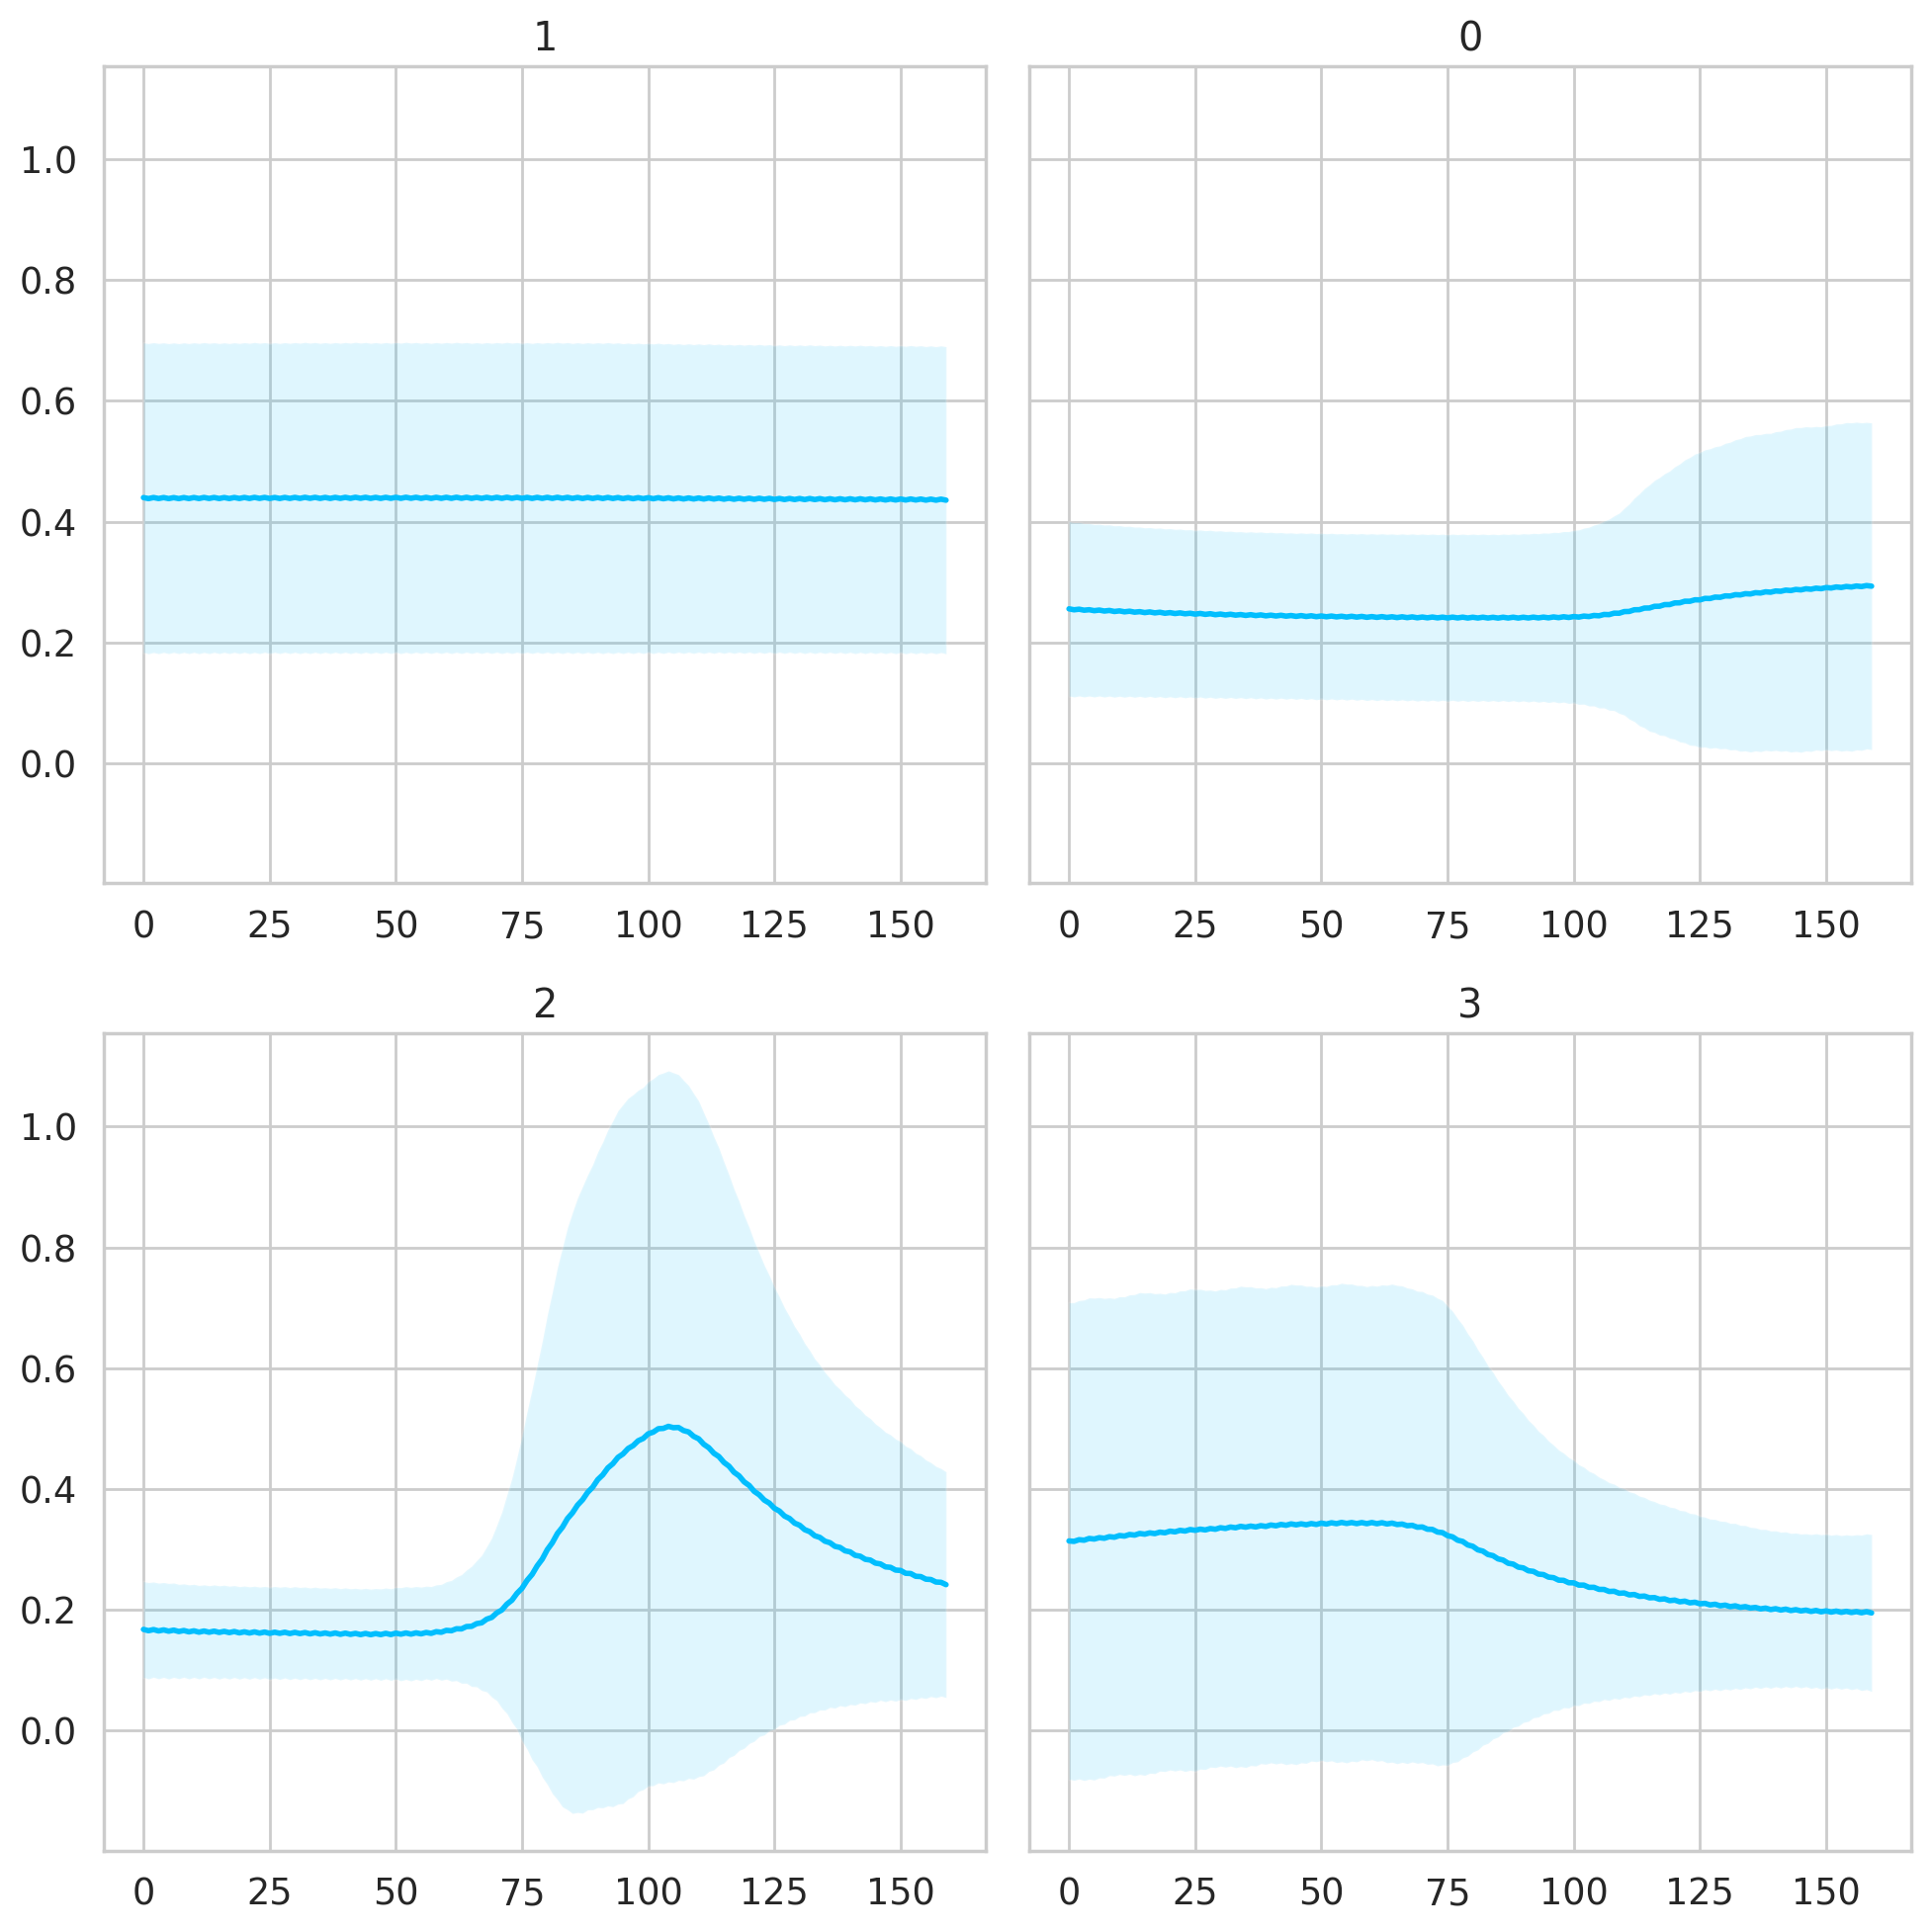

In [75]:
fig, axs = plt.subplots(
  nrows=len(classes) // 2,
  ncols=2,
  sharey=True,
  figsize=(10, 10)
)

for i, cls in enumerate(classes):
  # print(i)
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1)
  plot_time_series_with_sd(data, class_names[i], ax)

# fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [156]:
X_test_100_tensor_on_device = torch.tensor(X_test[0:100]).float().to(device=DEVICE)
X_test_100_tensor_on_device.shape

torch.Size([100, 160])

In [157]:
type(X_test_100_tensor_on_device)

torch.Tensor

In [18]:
# InceptionTime.eval()
explainer = shap.DeepExplainer(model, X_test_100_tensor_on_device)
X_test_100_SHAP = explainer.shap_values(X_test_100_tensor_on_device)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: hook 'deeplift_grad' has changed the type of value (was torch.cuda.FloatTensor got torch.FloatTensor)

In [29]:
X_test_100_SHAP[0]  # na CPU

array([[ 6.73483146e-06, -1.27163030e-05,  2.05241008e-07, ...,
        -7.23507910e-05,  2.24186861e-05,  1.13271444e-05],
       [-2.70311575e-05, -1.17517375e-04,  1.19422448e-05, ...,
         3.41516861e-05,  6.57392666e-05,  0.00000000e+00],
       [ 1.40143384e-05,  5.32941667e-05, -2.21168433e-04, ...,
        -4.23503152e-05, -5.10599093e-05, -9.51040784e-06],
       ...,
       [ 1.28475313e-06, -4.59168914e-05,  1.78933242e-05, ...,
         9.49238984e-06,  6.49713274e-06,  4.38031429e-06],
       [ 3.14679019e-05,  5.97296457e-05, -6.41654042e-05, ...,
         5.18099068e-06,  3.91172653e-05,  7.76813795e-06],
       [ 7.16282193e-06,  2.35060274e-04, -1.44239952e-04, ...,
         3.03271168e-04, -1.39881740e-04,  1.70287331e-05]])

In [28]:
X_test_100_SHAP[3]  # dlaczego to jest lista z 4 arrayami?

array([[-4.68324268e-09, -7.78991307e-06, -1.86835296e-05, ...,
        -6.98720833e-05, -5.19981040e-05, -1.80654279e-05],
       [-7.92414430e-05, -1.39742597e-05,  3.31681099e-06, ...,
         1.53524452e-05, -1.31746965e-05,  0.00000000e+00],
       [ 3.85133135e-05,  1.42992532e-04, -9.01961030e-05, ...,
        -4.97669898e-05, -2.60684701e-05, -2.70477244e-07],
       ...,
       [ 5.14448629e-06, -7.23419362e-06,  4.00030649e-06, ...,
         8.10083020e-06,  1.20915038e-05,  2.73770593e-06],
       [ 3.35011391e-05, -1.08611050e-04, -1.54114445e-04, ...,
         2.45381125e-05, -2.51481906e-05, -1.31246106e-05],
       [ 5.49108881e-06,  2.04398501e-04,  2.13488092e-05, ...,
         1.62407494e-04,  9.26198409e-05,  4.46518516e-06]])

# Mój model

In [10]:
class InceptionTime(nn.Module):
  def __init__(self):
    super(InceptionTime, self).__init__()
    self.unsqueeze = nn.ConstantPad1d((0, 0), 0)
    self.inception_block1 = InceptionBlock(
      in_channels=1,
      n_filters=32,
      kernel_sizes=[5, 11, 23],
      bottleneck_channels=32,
      use_residual=True,
      activation=nn.ReLU()
    )
    self.inception_block2 = InceptionBlock(
      in_channels=32 * 4,
      n_filters=32,
      kernel_sizes=[5, 11, 23],
      bottleneck_channels=32,
      use_residual=True,
      activation=nn.ReLU()
    )
    self.adaptive_avg_pool = nn.AdaptiveAvgPool1d(output_size=1)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=4 * 32 * 1, out_features=4)

  def forward(self, x):
    x = self.unsqueeze(x.unsqueeze(1))  # Reshape
    x = self.inception_block1(x)
    x = self.inception_block2(x)
    x = self.adaptive_avg_pool(x)
    x = self.flatten(x)  # Flatten
    # x = x.view(x.size(0), -1)  # Flatten
    x = self.linear(x)
    return x

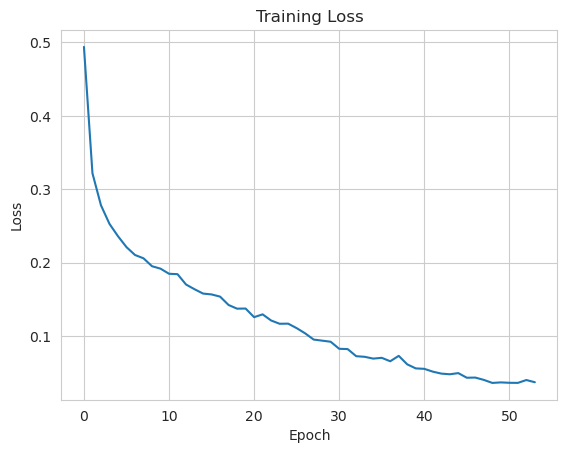

In [14]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Twój kod definiujący InceptionBlock, InceptionTime

# Przygotowanie danych treningowych
# n_samples = 500
# sequence_length = 160
# n_classes = 4
n_batch_size = 512

# Przykład sztucznych danych treningowych
# X = torch.randn(n_samples, sequence_length)
# y = torch.randint(0, n_classes, (n_samples,))

# Przekształć dane w TensorDataset i DataLoader
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train.astype('int')))
# train_dataset = TensorDataset(X, y)
train_dataloader = DataLoader(train_dataset, batch_size=n_batch_size, shuffle=True)

# Inicjalizacja modelu, optymalizatora i funkcji straty
inception_time_my_model = InceptionTime().to(DEVICE)
optimizer = Adam(inception_time_my_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Pętla treningowa
n_epochs = 100
patience = 5
best_loss = None
loss_history = []
early_stopping_counter = 0

for epoch in range(n_epochs):
  inception_time_my_model.train()
  running_loss = 0.0
  for batch_X, batch_y in train_dataloader:
    batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)

    optimizer.zero_grad()
    output = inception_time_my_model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_dataloader)
  loss_history.append(epoch_loss)
  print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

  # Early Stopping
  if best_loss is None or epoch_loss < best_loss:
    best_loss = epoch_loss
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  if early_stopping_counter >= patience:
    print(f"Early stopping triggered after {epoch+1} epochs")
    break

# Rysowanie przebiegu uczenia
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [13]:
torch.save(inception_time_my_model, CLASSFIER_MODEL_PATH)
inception_time_my_model

InceptionTime(
  (unsqueeze): ConstantPad1d(padding=(0, 0), value=0)
  (inception_block1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (conv_from_bottleneck_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(1, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  

In [11]:
inception_time_my_model = InceptionTime().to(DEVICE)
inception_time_my_model = torch.load(CLASSFIER_MODEL_PATH)
inception_time_my_model = inception_time_my_model.to(DEVICE)
inception_time_my_model.eval()

InceptionTime(
  (unsqueeze): ConstantPad1d(padding=(0, 0), value=0)
  (inception_block1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (conv_from_bottleneck_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(1, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  

In [64]:
def predict(model, dataset):
  model.eval()
  dataset_tensor_on_device = torch.tensor(dataset).float().to(device=DEVICE)
  with torch.no_grad():
    _pred = np.argmax(model(dataset_tensor_on_device).detach().cpu(), axis=1)
  return _pred



In [12]:
inception_time_my_model.eval()
X_test_tensor_on_device = torch.tensor(X_test).float().to(device=DEVICE)
with torch.no_grad():
  x_pred = np.argmax(inception_time_my_model(X_test_tensor_on_device).detach().cpu(), axis=1)
x_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

In [13]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.7751385167239692

In [90]:
explainer = shap.DeepExplainer(inception_time_my_model, X_test_100_tensor_on_device)
X_test_100_SHAP = explainer.shap_values(X_test_100_tensor_on_device)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: hook 'deeplift_grad' has changed the type of value (was torch.cuda.FloatTensor got torch.FloatTensor)

# SHAP

In [20]:
X_test.shape

(16736, 160)

In [24]:
_, X_test_baseline_tensor, _, y_test_baseline_tensor = train_test_split(X_test, y_test, test_size=1000, random_state=2023)
# X_test_baseline_tensor_on_device = torch.tensor(X_test_baseline_tensor).float().to(device=DEVICE)
X_test_baseline_tensor.shape

(1000, 160)

In [32]:
X_test_baseline_tensor = shap.sample(X_test, 100)
X_test_baseline_tensor.shape

(100, 160)

In [150]:
type(X_test_baseline_tensor)

numpy.ndarray

In [180]:
class InceptionTimeWrapper:
  def __init__(self, model, device):
    self.model = model.to(device)
    self.device = device

  def predict(self, x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(self.device)
    with torch.no_grad():
      self.model.eval()
      output = self.model(x_tensor).cpu().numpy()
    return output

# inception_time_my_model_wrapped = InceptionTimeWrapper(inception_time_my_model, DEVICE)
inception_time_original_model_wrapped = InceptionTimeWrapper(inception_time_original_model, DEVICE)

In [39]:
torch.cuda.empty_cache()
explainer_kernel = shap.KernelExplainer(inception_time_original_model_wrapped.predict, X_test_baseline_tensor)
X_test_100_SHAP_kernel = explainer_kernel.shap_values(X_test[0:100], nsamples=160*2)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [45]:
type(X_test_100_SHAP_kernel)

list

In [47]:
len(X_test_100_SHAP_kernel)  # for every class

4

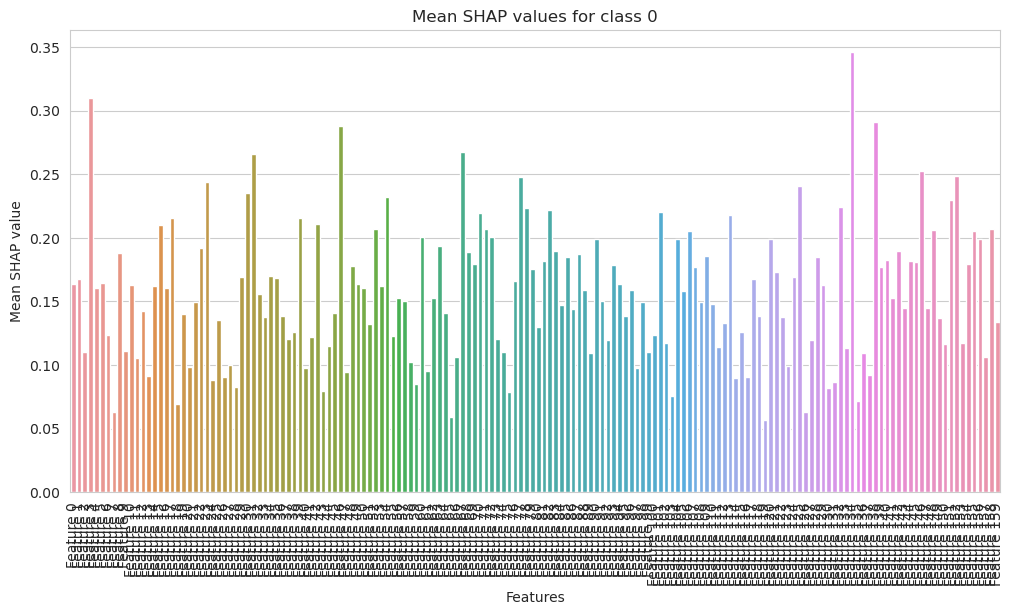

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_shap_values(shap_values, feature_names=None, class_index=0):
  shap_matrix = np.array(shap_values[class_index])
  mean_abs_shap_values = np.mean(np.abs(shap_matrix), axis=0)

  if feature_names is None:
    feature_names = [f"Feature {i}" for i in range(shap_matrix.shape[1])]

  plt.figure(figsize=(12, 6))
  sns.barplot(x=feature_names, y=mean_abs_shap_values)
  plt.title(f"Mean SHAP values for class {class_index}")
  plt.xlabel("Features")
  plt.ylabel("Mean SHAP value")
  plt.xticks(rotation=90)
  plt.show()

# Wizualizacja wartości SHAP
plot_shap_values(X_test_100_SHAP_kernel)


In [54]:
%%capture
# import sys
# import io
# import contextlib
# temp_stdout = io.StringIO()

torch.cuda.empty_cache()
# with contextlib.redirect_stdout(temp_stdout):
X_test_SHAP_kernel = explainer_kernel.shap_values(X_test, nsamples=160*2)

In [57]:
import pickle

pickle_out = open(f'{DATA_DIRECTORY}/X_test_SHAP_kernel.pkl',"wb")
pickle.dump(X_test_SHAP_kernel, pickle_out)
pickle_out.close()

In [61]:
len(X_test_SHAP_kernel)

4

In [66]:
predict(inception_time_original_model, X_test)

tensor([1, 1, 1,  ..., 3, 1, 0])

In [90]:
_class_indexes = y_test ==  0
[k for k in range(len(_class_indexes)) if _class_indexes[k]][1]

23

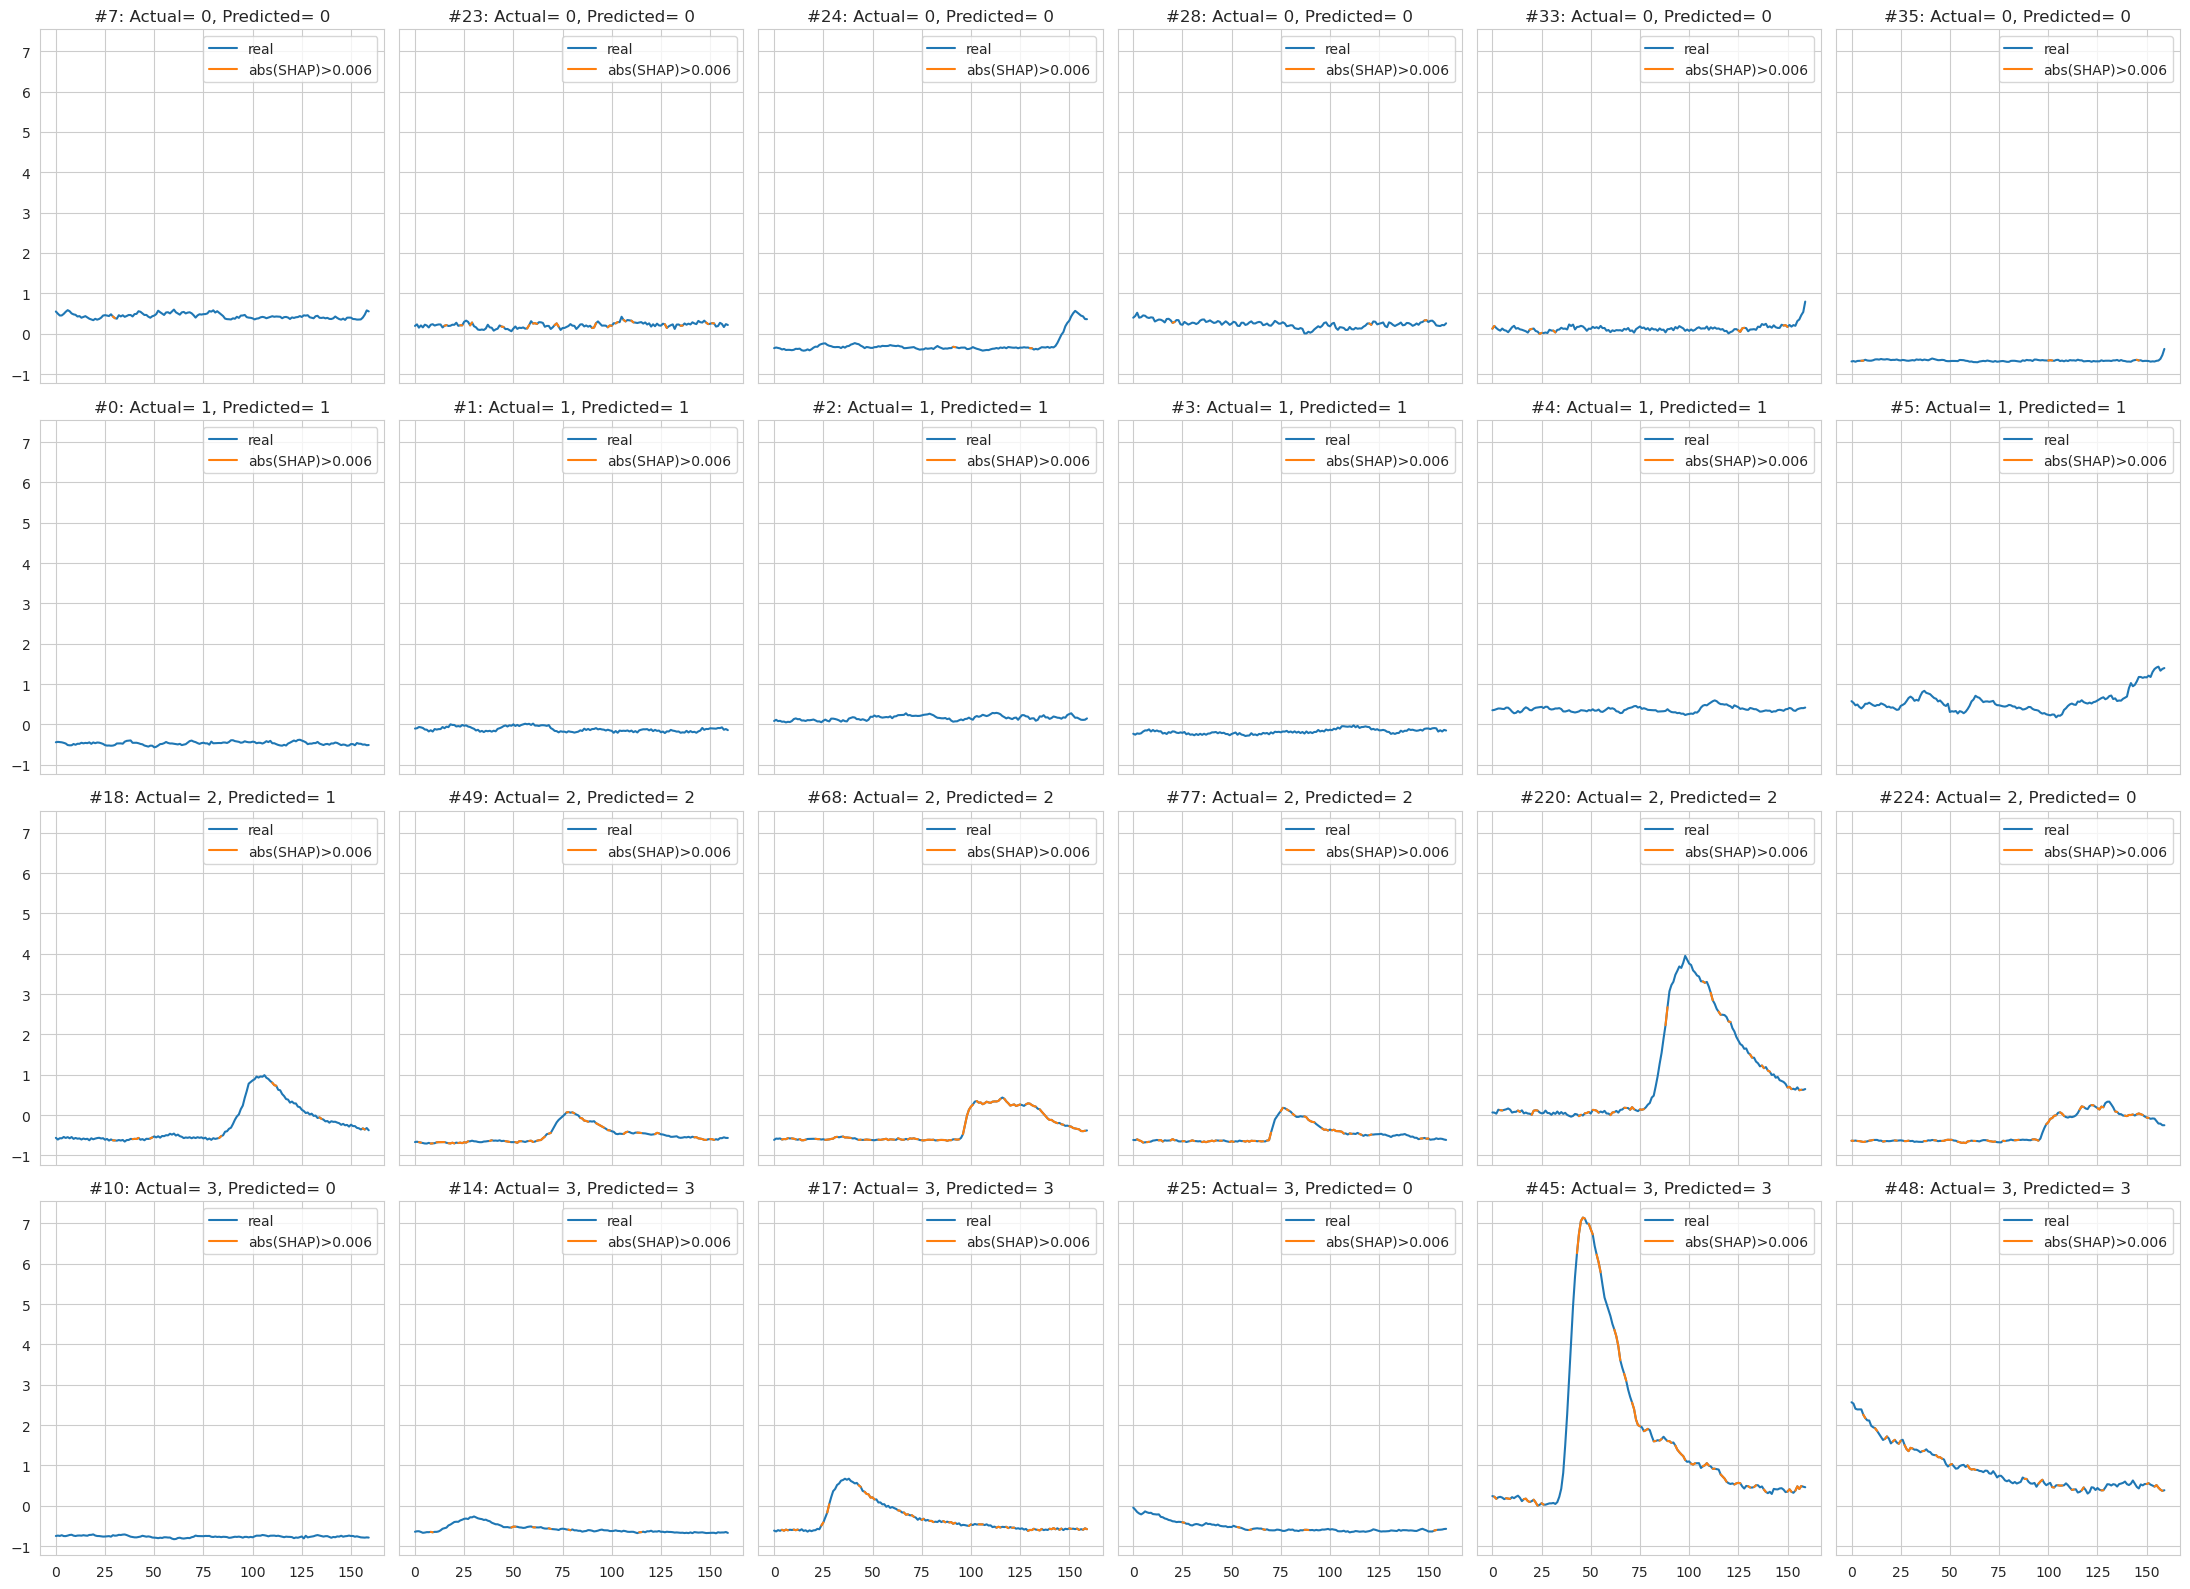

In [91]:
def plot_shap_color(data, shap, model, title, ax, delta=0.006):
  ax.plot(data, label='real')

  # predictions = predict(model, data)
  # ax.plot(predictions[0], label='reconstructed')

  # ax.plot([s * 10 for s in shap], label='shap * 10')
  data_sh = [] # data.copy()
  # data_sh[[abs(sh) < delta for sh in shap]] = np.nan
  for i, sh in enumerate(shap):
    if abs(sh) < delta:
      data_sh.append(np.nan)
    else:
      data_sh.append(data[i])
  # print(data_sh)
  ax.plot(data_sh, label=f'abs(SHAP)>{delta}')
  ax.set_title(f'{title}')
  ax.legend()


CHARTS_IN_ROW = 6
CLASSES = 4
fig, axs = plt.subplots(
  nrows=CLASSES,
  ncols=CHARTS_IN_ROW,
  sharey=True,
  sharex=True,
  figsize=(22, 16)
)

for j in range(CLASSES):
  _class_indexes = y_test == j
  _class_indexes = [k for k in range(len(_class_indexes)) if _class_indexes[k]]
  for k in range(CHARTS_IN_ROW):
    i = _class_indexes[k]
    _data = X_test[i].tolist()
    _y = int(y_test[i].tolist())
    _y_pred = predict(inception_time_original_model, _data).item()
    _shap = X_test_SHAP_kernel[j][i].tolist()
    plot_shap_color(_data, _shap, inception_time_original_model, title=f'#{i}: Actual= {_y}, Predicted= {_y_pred}', ax=axs[j, k])

fig.tight_layout()

In [136]:
X_test[[1,2,3]]
len(X_test)
X_test.shape#[0]
# pd.DataFrame(pd.DataFrame(X_test).applymap(cell_max).mean(axis=0))

(16736, 160)

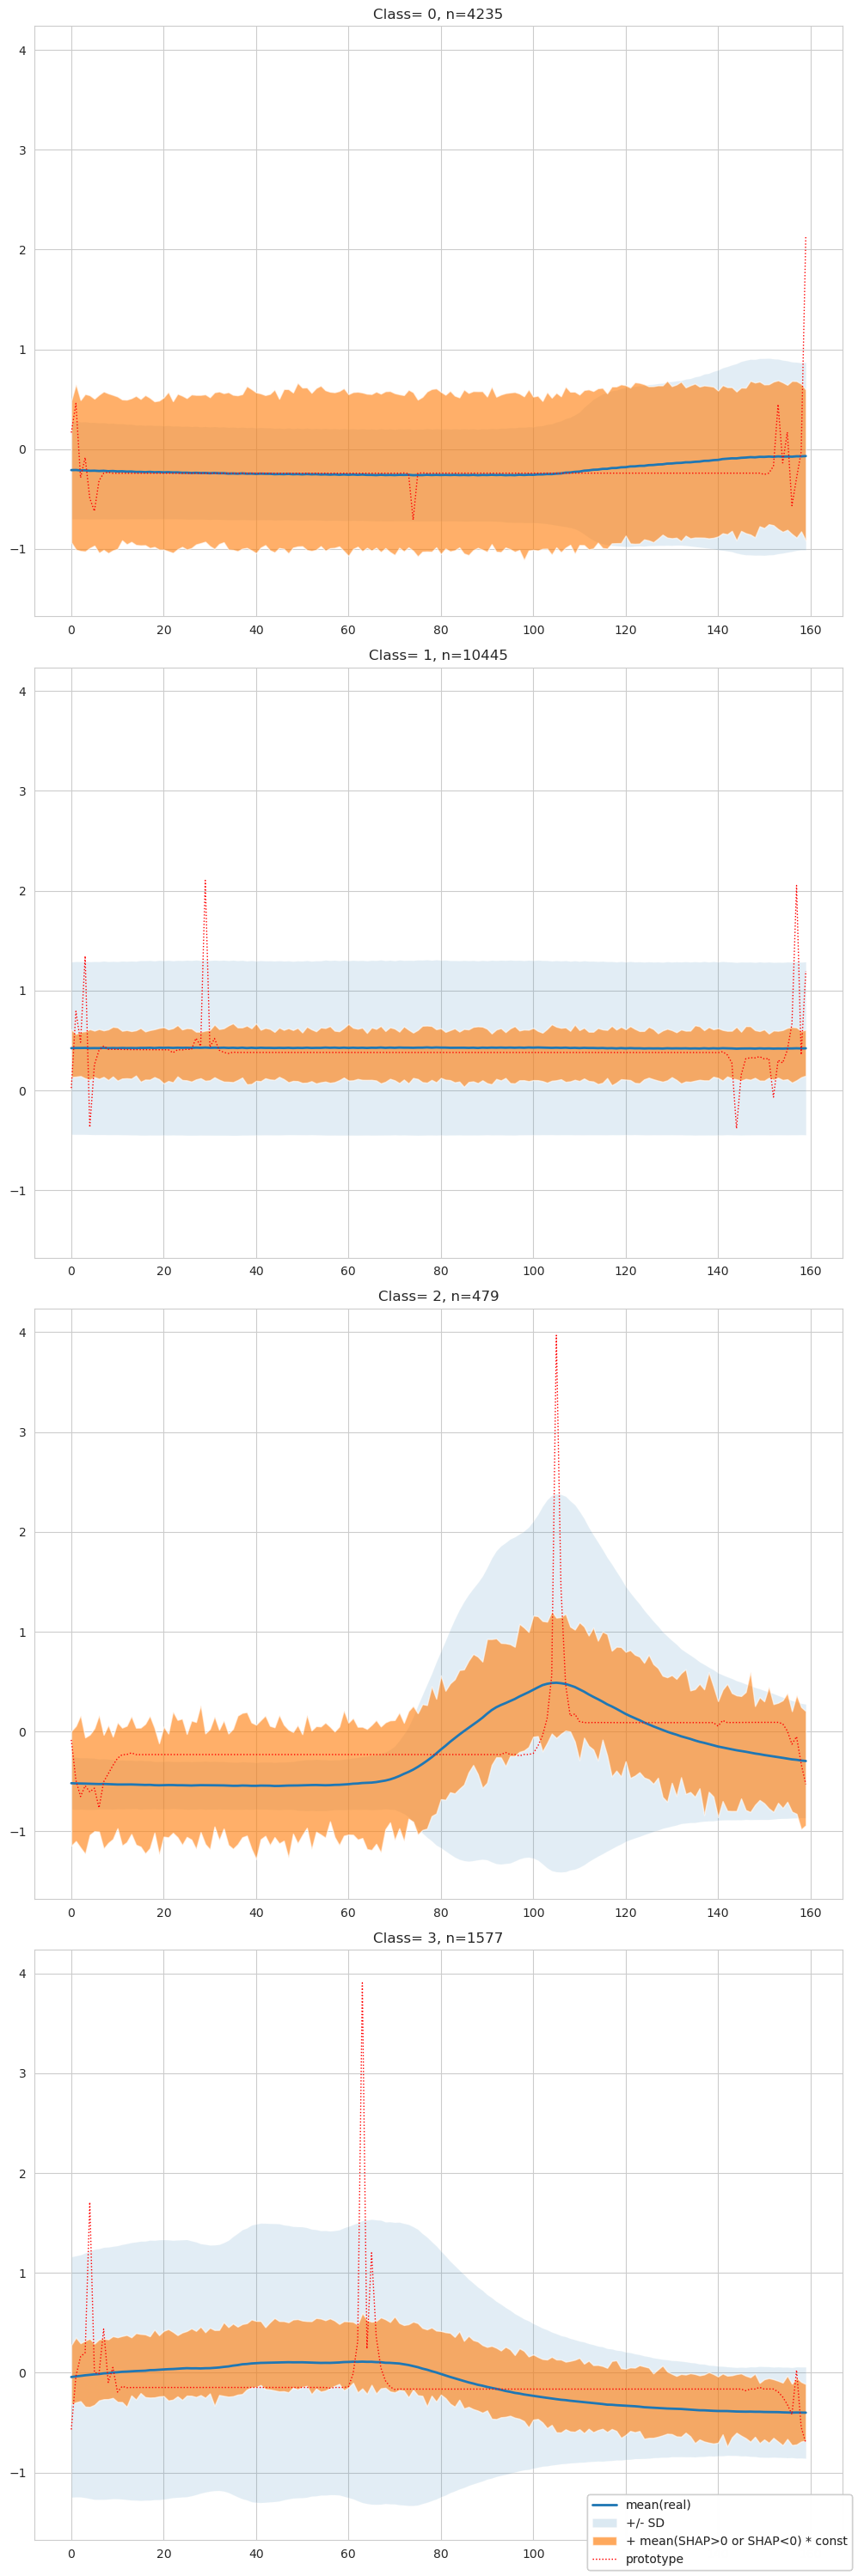

In [133]:
def cell_max(x):
  return max(x, 0.0)

def cell_min(x):
  return min(x, 0.0)

def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

def plot_shap_with_prediction_loss(data_np, shap_np_for_class, class_name, ax, shap_method=0, shap_multiplier=50):
  time_series_df_mean = pd.DataFrame(data_np.mean(axis=0))
  time_series_df_std = pd.DataFrame(data_np.std(axis=0))

  time_series_df_dtw_barycenter = dtw_barycenter_averaging(data_np).flatten()

  smooth_path = time_series_df_mean
  path_deviation = 1 * time_series_df_std

  sd_under_line = (smooth_path - path_deviation)[0]
  sd_over_line = (smooth_path + path_deviation)[0]

  shap_df = pd.DataFrame(shap_np_for_class)
  shap_df_up = pd.DataFrame(shap_df.applymap(cell_max).mean(axis=0))
  shap_df_down = pd.DataFrame(shap_df.applymap(cell_min).mean(axis=0))
  if shap_method == 0:
    shap_under_line = (smooth_path + shap_df_down * shap_multiplier)[0]
    shap_over_line = (smooth_path + shap_df_up * shap_multiplier)[0]
  elif shap_method == 1:
    shap_under_line = (smooth_path - np.abs(smooth_path * shap_df_down * shap_multiplier))[0]
    shap_over_line = (smooth_path + np.abs(smooth_path * shap_df_up * shap_multiplier))[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    sd_under_line,
    sd_over_line,
    alpha=.125
  )
  if shap_method >= 0:
    ax.fill_between(
      path_deviation.index,
      shap_under_line,
      shap_over_line,
      alpha=.625
    )

  ax.plot(time_series_df_dtw_barycenter, 'r:', linewidth=1)
  ax.set_title(f"{class_name}, n={data_np.shape[0]}")


fig, axs = plt.subplots(
  nrows=4,
  ncols=1,
  sharey=True,
  figsize=(10, 30)
)

for j in range(CLASSES):
  _class_indexes = y_test == j
  _class_indexes = [k for k in range(len(_class_indexes)) if _class_indexes[k]]

  ax = axs.flat[j]
  plot_shap_with_prediction_loss(X_test[_class_indexes], X_test_SHAP_kernel[j], f'Class= {j}', ax, shap_method=0, shap_multiplier=10)

  fig.legend(['mean(real)', '+/- SD', '+ mean(SHAP>0 or SHAP<0) * const', 'prototype'], loc='lower right')

# fig.delaxes(axs.flat[-1])
fig.tight_layout();


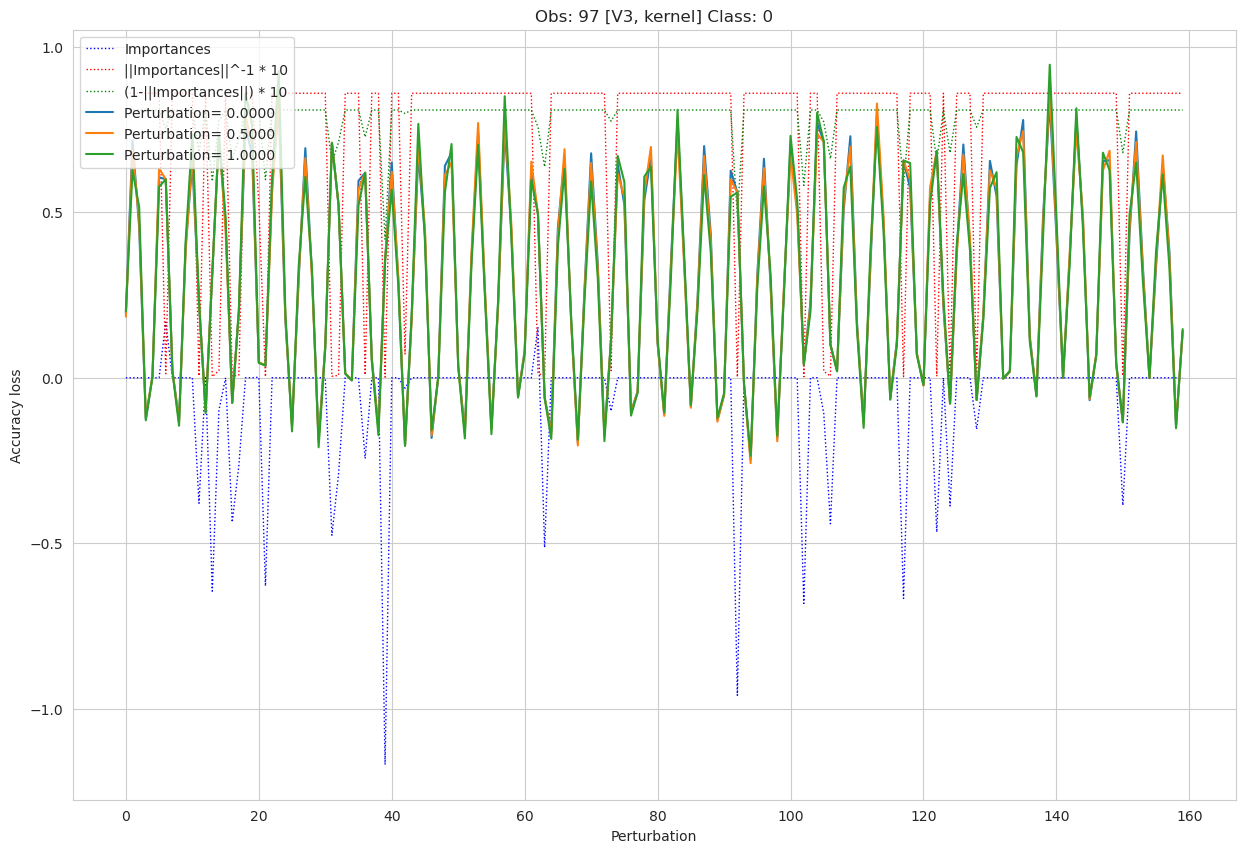

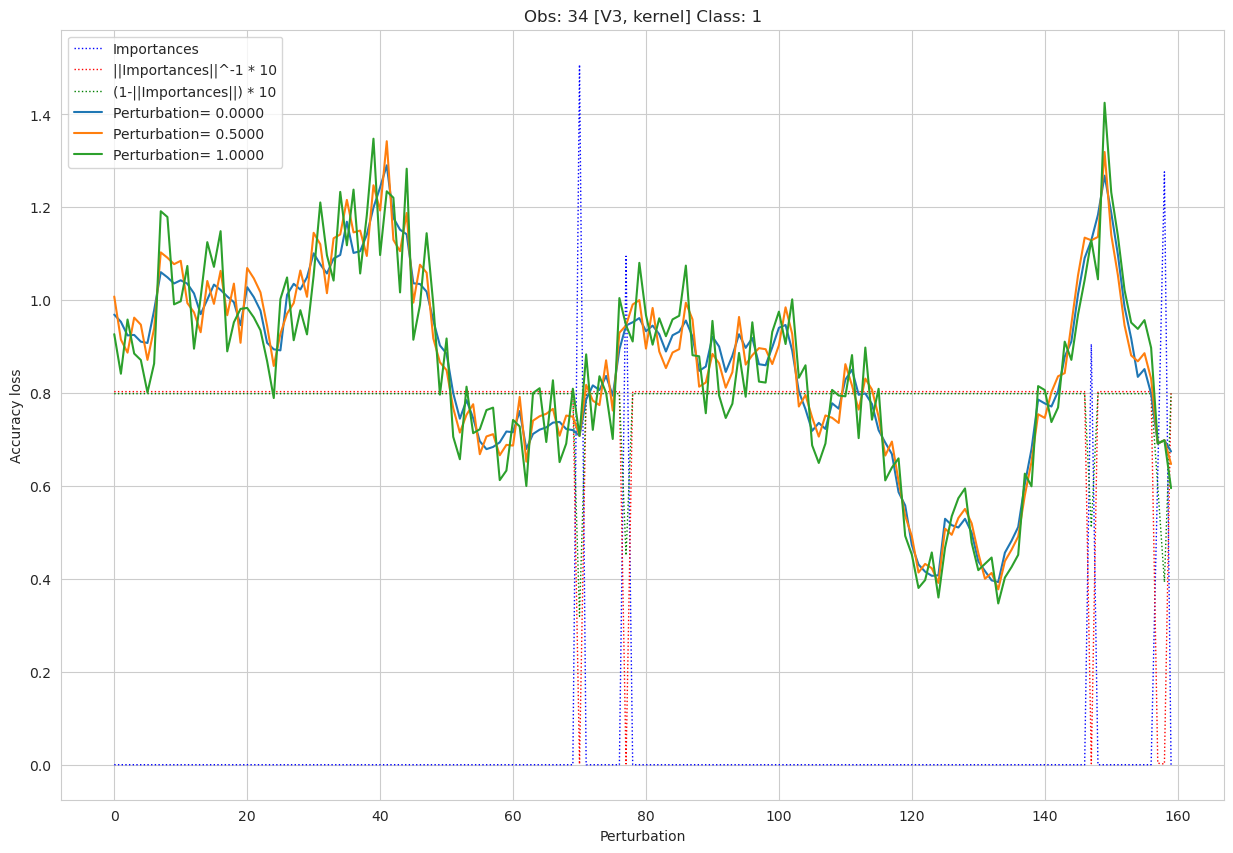

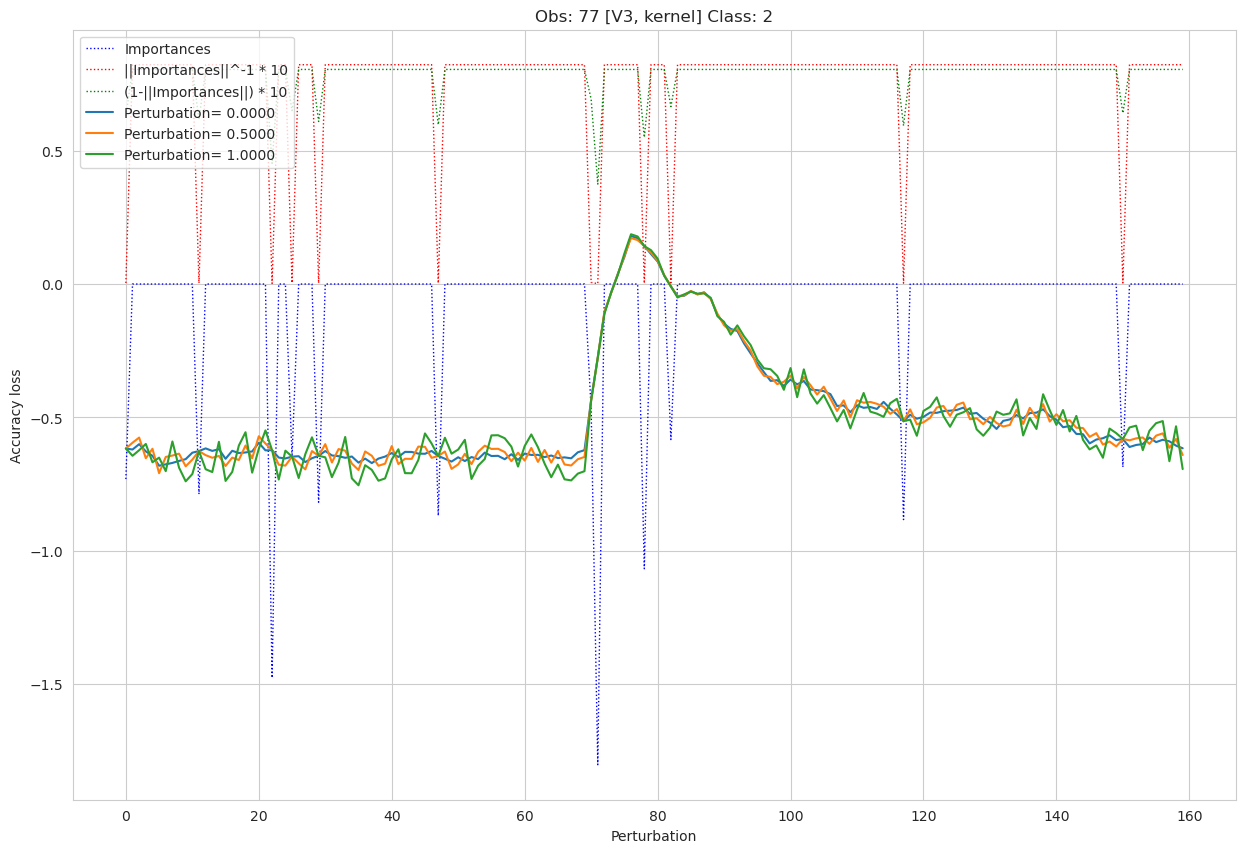

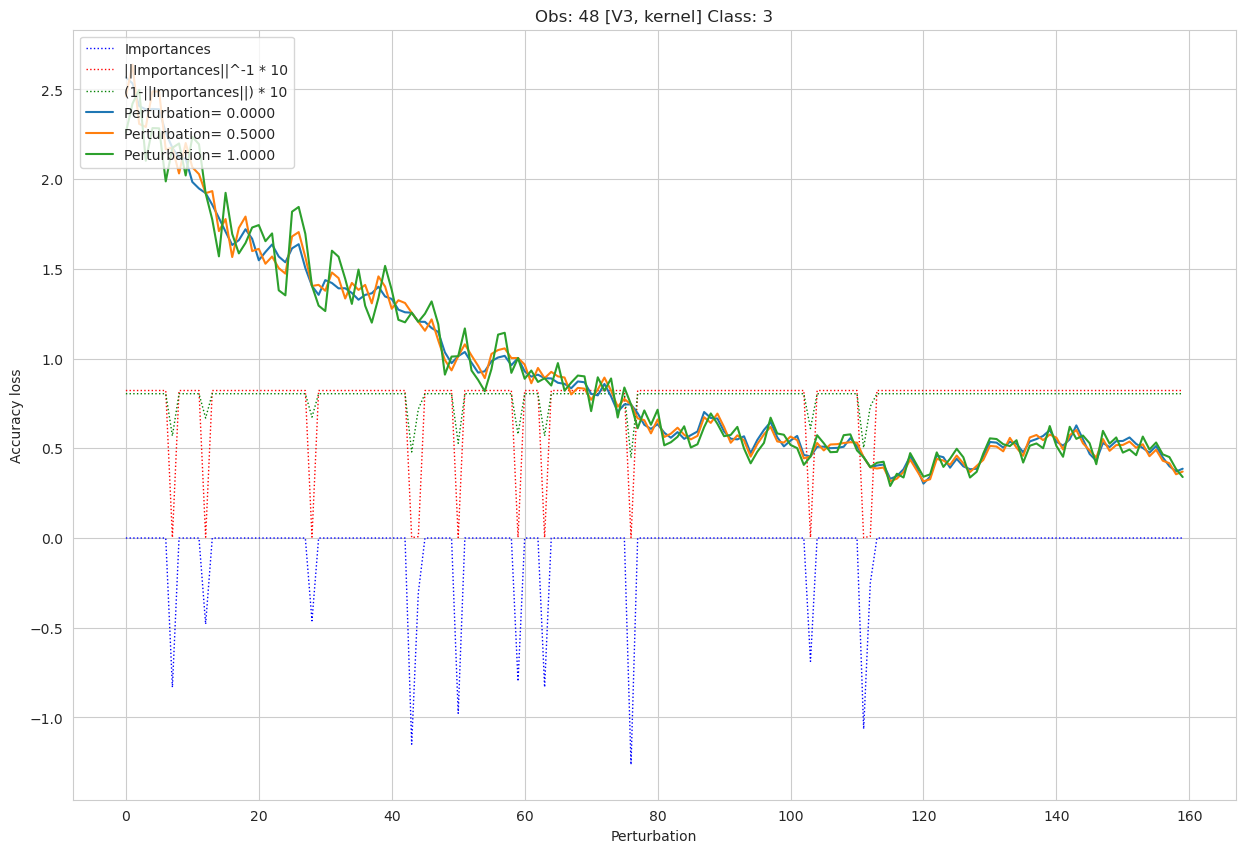

In [186]:
def get_random_sign():
  return [-1,1][random.randrange(2)]

def plot_single_AUC_perturb_acc_loss(series, legend:str):
  _acc_perturbed_loss = [(x[0], series[0][1] - x[1]) for x in series]
  auc1 = 1- np.sum([x[1] for x in series]) / (len(series) * series[0][1])
  plt.plot(*zip(*_acc_perturbed_loss), label=f"{legend}: AUC= {auc1:.4f}")

def prototypical_permutations_v3(perturbation_perc, observation, importances, prototype):
  _importances = importances / np.linalg.norm(importances)
  _importances_inv = 1 / np.abs(_importances + 0.001)
  _importances_inv = _importances_inv/ np.linalg.norm(_importances_inv)
  if prototype is not None:
    _perturbation = np.multiply(prototype, _importances_inv) * perturbation_perc  # perturbation around prototype
  else:
    _perturbation = np.multiply(observation, _importances_inv) * perturbation_perc  # perturbation around observation
  return observation + [p * get_random_sign() for p in _perturbation]

def plot_perturbartion_for_single_obs(N, X_df, y_df, importances_list, permutations_fn, label, importances_plot_const, range_list=None):

  _obs = X_df.iloc[N]
  _class = int(y_df.iloc[N][0])
  importances_df = pd.DataFrame(importances_list[_cl])
  importances = importances_df.iloc[N]
  # _class = ['0', '1', '2', '3'][_cl]
  # plt.plot(_obs, 'c', linewidth=1, label="Original")
  plt.figure(figsize=(15,10))
  plt.plot(1 * importances, 'b:', linewidth=1, label="Importances")
  _importances = importances / np.linalg.norm(importances)

  _importances_inv = 1 / np.abs(_importances + 0.001)
  _importances_inv = _importances_inv / np.linalg.norm(_importances_inv)
  plt.plot(importances_plot_const * _importances_inv, 'r:', linewidth=1, label=f"||Importances||^-1 * {importances_plot_const}")

  _importances_inv = 1 - np.absolute(_importances)  # should be proportional to the least important features
  _importances_inv = _importances_inv/ np.linalg.norm(_importances_inv)  # normalised
  plt.plot(importances_plot_const * _importances_inv, 'g:', linewidth=1, label=f"(1-||Importances||) * {importances_plot_const}")

  if range_list is None:
    range_list = [x for x in range(0, 101, 50)]
  for _p in range_list:
    _p = _p/100
    _obs = permutations_fn(_p, _obs, importances, None)

    plt.plot(_obs, label=f"Perturbation= {_p:.4f}")

  plt.title(f"{label} Class: {_class}")
  plt.xlabel('Perturbation')
  plt.ylabel('Accuracy loss')
  plt.legend(loc="upper left")
  plt.show()

plot_perturbartion_for_single_obs(97,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {97} [V3, kernel]", 10)

plot_perturbartion_for_single_obs(34,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {34} [V3, kernel]", 10)


plot_perturbartion_for_single_obs(77,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {77} [V3, kernel]", 10)

plot_perturbartion_for_single_obs(48,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {48} [V3, kernel]", 10)



In [138]:
def dataset_perturbation(perturbation_perc, X_df, y_df, importances_list_for_classes, prototypical_permutations_fn, prototype_fn):
  _perturbed = []
  _prototype = None
  _perturbation_perc = perturbation_perc * len(X_df.columns)
  for ( idxRow, _obs ), ( _, _class ) in zip(X_df.iterrows(), y_df.iterrows() ):
    _class = int(_class)
    # _class = int(y_df.iloc[N][0])
    s2 = importances_list_for_classes[_class][idxRow]
    if prototype_fn is not None:
      _prototype = prototype_fn(idxRow)
    _perturbed.append(prototypical_permutations_fn(_perturbation_perc, _obs, s2, _prototype))
  return pd.DataFrame(_perturbed)

perturbed_tmp = dataset_perturbation(0.1, pd.DataFrame(X_test), pd.DataFrame(y_test), X_test_SHAP_kernel, prototypical_permutations_v3, None)

invalid value encountered in true_divide


In [139]:
perturbed_tmp

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,-1.010985,-0.988972,0.123234,-1.014533,-1.043921,0.133365,0.143892,0.145995,0.145461,0.136725,...,-1.111689,-1.118364,-1.178320,0.129916,-1.094103,0.135160,-1.145376,-1.135652,-1.178429,0.143797
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16732,-0.496821,-0.584660,-0.656696,-0.591236,-1.937752,-1.964004,-0.557468,-0.556213,-0.529718,-0.502689,...,-0.526093,-0.450763,-0.512827,0.666948,-0.506445,-0.579192,0.652328,-0.549809,-0.430310,0.740217
16733,-1.046265,0.178524,-0.398985,0.178757,-1.037115,-1.011182,0.182184,0.182068,-1.061073,0.187053,...,-1.510179,0.268103,-1.517534,-1.484093,-1.549611,-0.620230,-1.519488,0.269852,0.271795,-1.533497
16734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
print(X_test[1])
print(y_test[1])

[-0.10383898 -0.09605123 -0.0656175  -0.07390608 -0.08923324 -0.1267295
 -0.13201497 -0.17504009 -0.14647812 -0.17720843 -0.11603094 -0.12913554
 -0.11765491 -0.11666667 -0.06594724 -0.09479306 -0.05611972 -0.06795728
  0.00053333 -0.01361089 -0.01520811 -0.05203816 -0.04126731 -0.05450063
 -0.01546976 -0.0334046  -0.02511858 -0.05344735 -0.06510139 -0.09005879
 -0.10974633 -0.15033378 -0.13480147 -0.18149038 -0.16162426 -0.19042525
 -0.15923056 -0.17013889 -0.15889096 -0.18038482 -0.15697248 -0.17124567
 -0.11164402 -0.09509856 -0.07416795 -0.0433796  -0.02504663 -0.05275428
 -0.02236422 -0.03477218  0.         -0.03918694 -0.01329345 -0.04072127
 -0.0151838   0.          0.01574488  0.00373408  0.01412204 -0.01334401
  0.01892829 -0.02945096 -0.02904343 -0.03889185 -0.022915   -0.02004812
 -0.02538749 -0.03715336 -0.01786667 -0.09134615 -0.11886994 -0.1609717
 -0.16759925 -0.19764267 -0.17049093 -0.1823042  -0.18029939 -0.20030755
 -0.17022412 -0.18278995 -0.1891171  -0.20384205 -0.1

In [146]:
print(X_test_SHAP_kernel[0][1])
print(X_test_SHAP_kernel[1][1])
print(X_test_SHAP_kernel[2][1])
print(X_test_SHAP_kernel[3][1])

[ 0.          0.          0.          0.          0.         -0.17569229
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.47374087  0.         -0.0937738   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.50432388  0.          0.          0.          0.
  0.          0. 

In [158]:
torch.cuda.empty_cache()
X_test_baseline_tensor_on_device = torch.tensor(X_test_baseline_tensor).float().to(device=DEVICE)
explainer_deep = shap.DeepExplainer(inception_time_original_model, X_test_baseline_tensor_on_device)
X_test_100_SHAP_deep = explainer_deep.shap_values(X_test_100_tensor_on_device)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: hook 'deeplift_grad' has changed the type of value (was torch.cuda.FloatTensor got torch.FloatTensor)

In [167]:
%%capture

# torch.cuda.empty_cache()
X_test_baseline_tensor_on_cpu = torch.tensor(X_test_baseline_tensor).float().to(device='cpu')
# X_test_baseline_tensor_on_cpu.requires_grad_(True)

inception_time_original_model_cpu = nn.Sequential(
  Reshape(out_shape=(1,160)),
  InceptionBlock(
    in_channels=1,
    n_filters=32,
    kernel_sizes=[5, 11, 23],
    bottleneck_channels=32,
    use_residual=True,
    activation=nn.ReLU()
  ),
  InceptionBlock(
    in_channels=32*4,
    n_filters=32,
    kernel_sizes=[5, 11, 23],
    bottleneck_channels=32,
    use_residual=True,
    activation=nn.ReLU()
  ),
  nn.AdaptiveAvgPool1d(output_size=1),
  Flatten(out_features=32*4*1),
  nn.Linear(in_features=4*32*1, out_features=4)
)

inception_time_original_model_cpu.load_state_dict(torch.load(
  MODEL_DIRECTORY + "/InceptionTime_full-version_lr-{5e-3,1e-3,2e-4},_bs-512_ks-[5,11,23]_100-epochs_state_dict.pt"))

# inception_time_original_model_cpu = inception_time_original_model.to(device='cpu')
print(next(inception_time_original_model_cpu.parameters()).is_cuda)
inception_time_original_model_cpu.eval()
# inception_time_original_model_cpu.requires_grad_(True)
# for param in inception_time_original_model_cpu.parameters():
#   param.requires_grad_(True)

explainer_deep = shap.DeepExplainer(inception_time_original_model_cpu, X_test_baseline_tensor_on_cpu)
X_test_100_SHAP_deep = explainer_deep.shap_values(X_test_100_tensor_on_device.to(device='cpu'))

In [168]:
# porównanie z kernel - zupełnie co innego
print(X_test_100_SHAP_deep[0][1])
print(X_test_100_SHAP_deep[1][1])
print(X_test_100_SHAP_deep[2][1])
print(X_test_100_SHAP_deep[3][1])

[-8.96734273e-05 -9.66005100e-05 -1.16133488e-05  5.87182112e-05
  4.53221473e-05  1.72750821e-04  7.35292851e-05  1.51211469e-04
  6.42477025e-05  1.07590306e-04  9.65513464e-05  5.79947373e-05
  2.00256254e-05  2.32690480e-04 -1.29674911e-04  6.05711539e-05
 -6.41211009e-05  6.82379323e-05 -8.99649385e-05  1.95618297e-04
  1.28708853e-04 -1.37734123e-05 -6.66958977e-06  1.05695777e-04
  5.44670984e-05  1.86957215e-04  2.60450208e-04  7.33879933e-05
  3.74241848e-04  3.40049563e-04  4.64794612e-05 -2.15908178e-04
  1.16231422e-04  1.42090503e-04  6.90832894e-05  2.08713973e-04
 -1.18296623e-04  3.14512989e-04 -5.09776582e-05  1.91678744e-04
 -1.23083155e-04 -2.68588410e-05  2.35130701e-05  8.76164122e-05
  1.69041377e-05  2.47608376e-04  2.28837816e-04  6.72296082e-05
 -1.01671521e-05  9.90566405e-05  2.41975955e-04 -6.90286543e-05
  9.67565720e-05 -1.63311761e-05  1.11365356e-04  1.83734053e-04
  7.76560628e-05  1.52451612e-05  3.80999292e-04  4.82285068e-05
  1.33283640e-04  1.41864

In [182]:
print(X_test_SHAP_kernel[0][48])
print(X_test_SHAP_kernel[1][48])
print(X_test_SHAP_kernel[2][48])
print(X_test_SHAP_kernel[3][48])

[0.         0.         0.         0.         0.         0.
 0.         0.89091885 0.         0.         0.         0.
 0.31718651 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.65490214 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

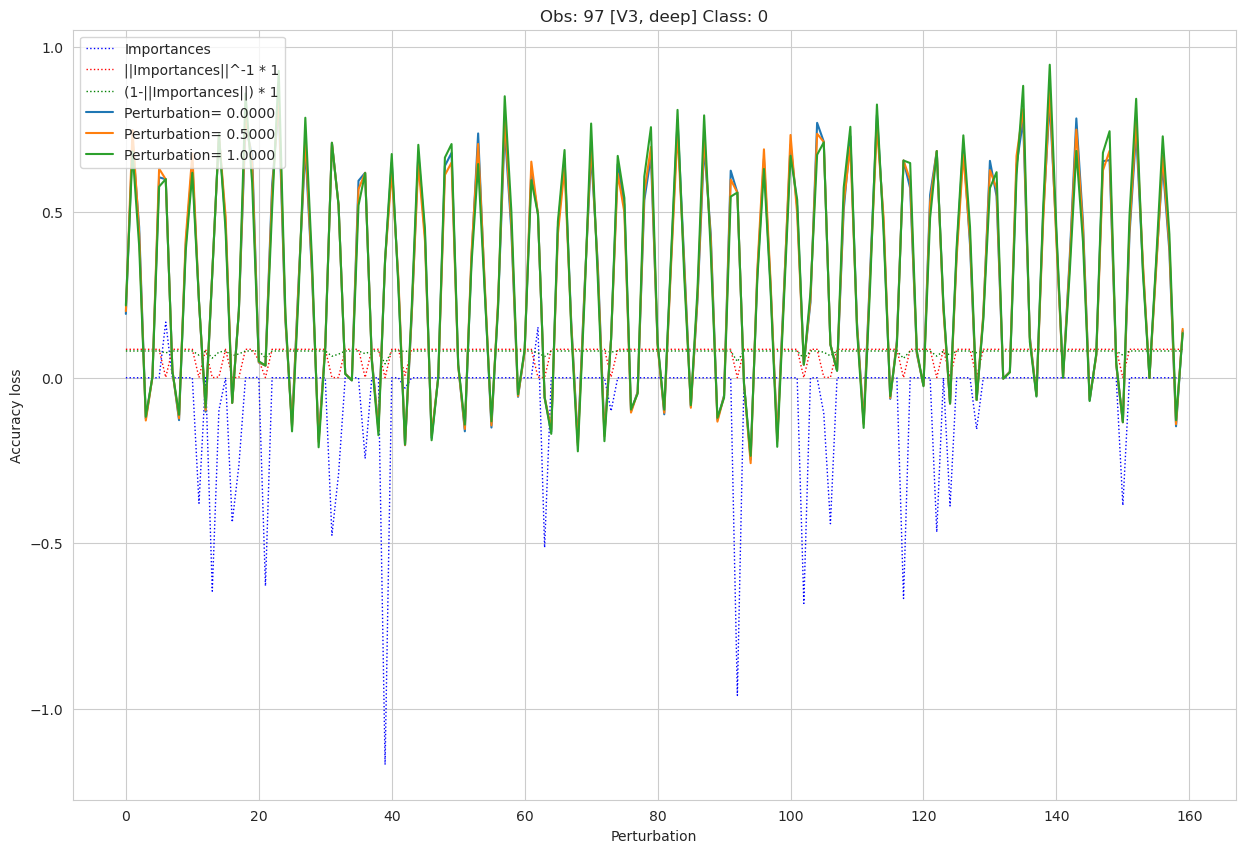

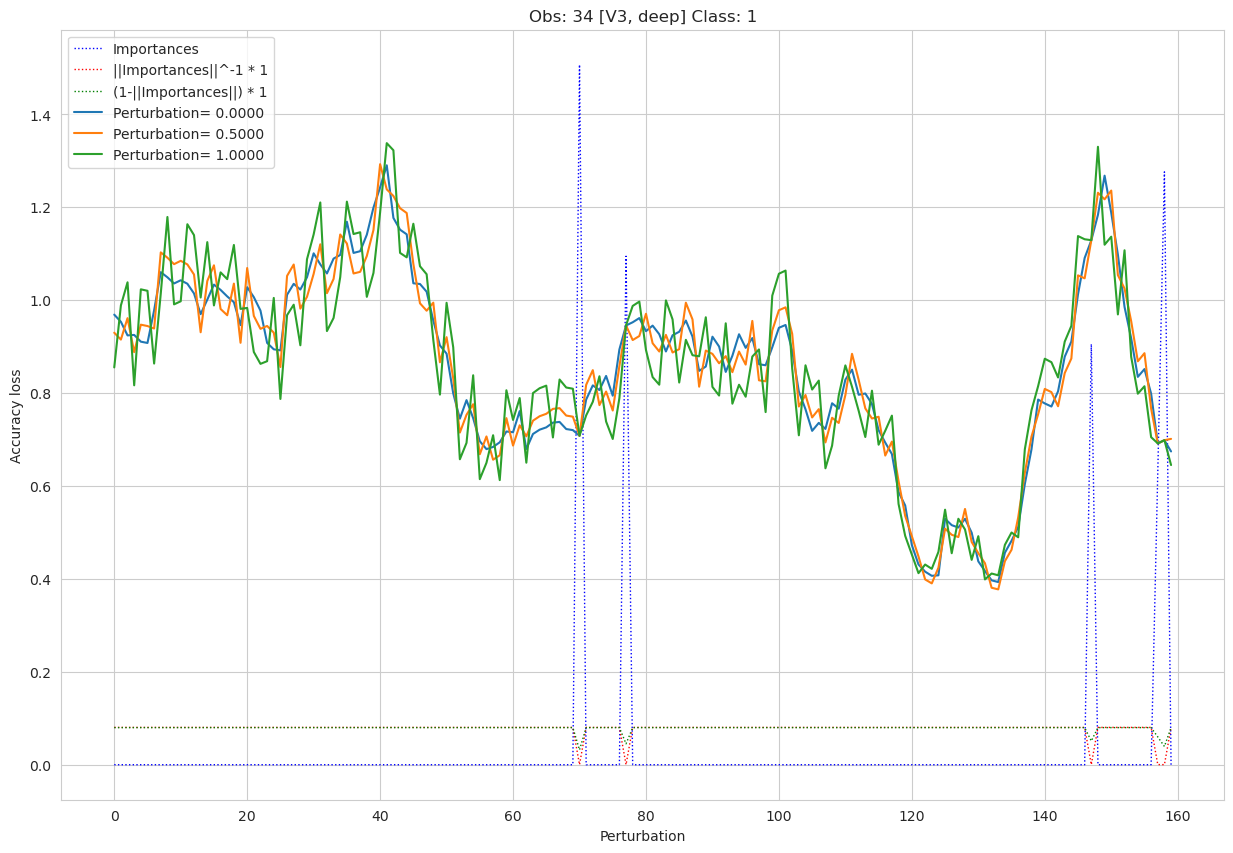

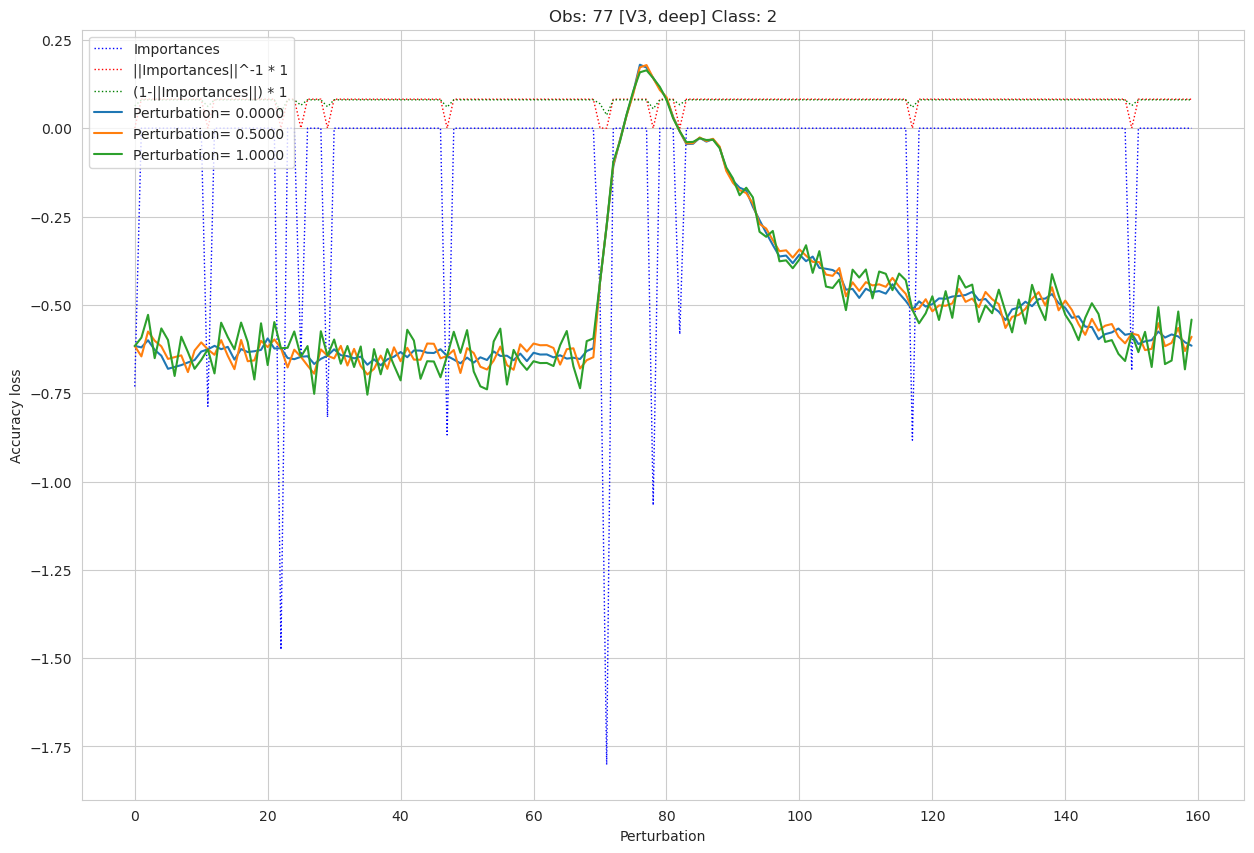

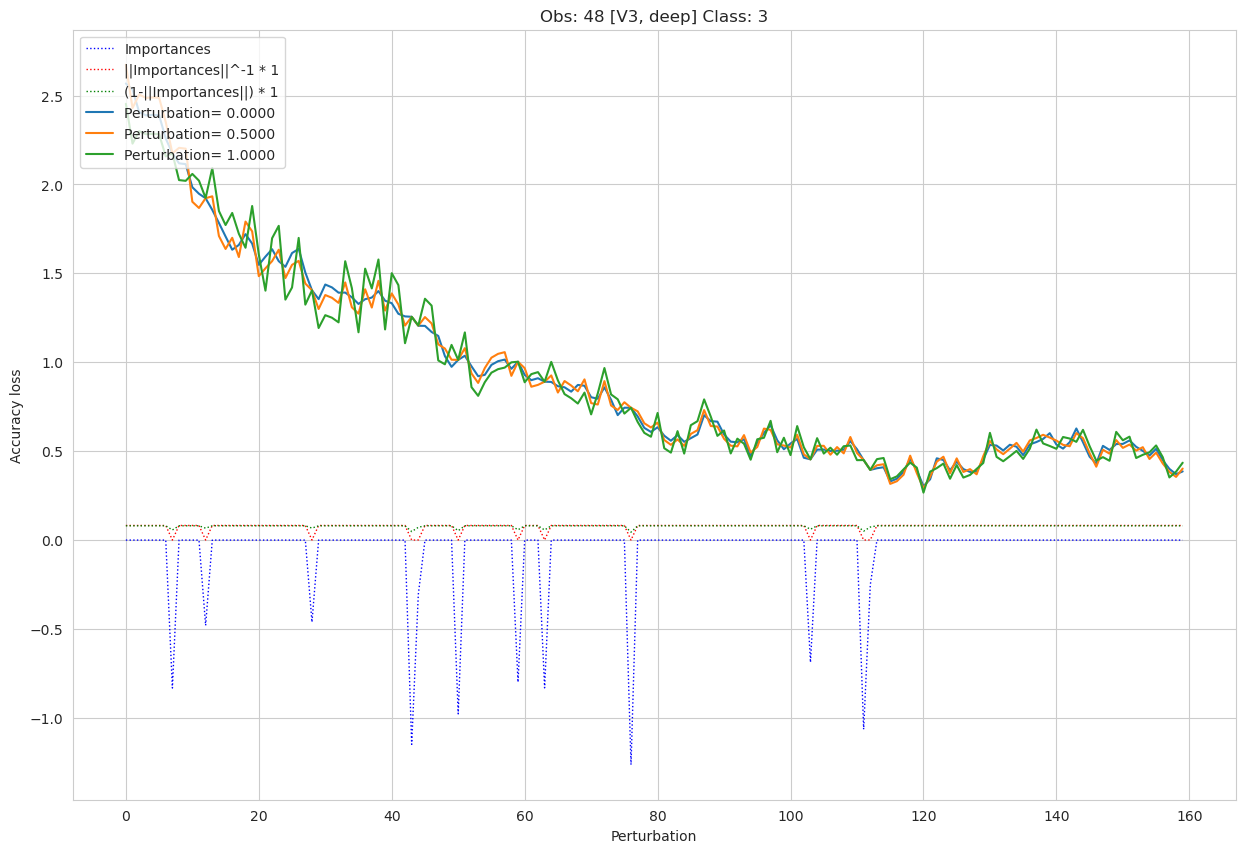

In [185]:
plot_perturbartion_for_single_obs(97,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {97} [V3, deep]", 1)

plot_perturbartion_for_single_obs(34,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {34} [V3, deep]", 1)


plot_perturbartion_for_single_obs(77,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {77} [V3, deep]", 1)

plot_perturbartion_for_single_obs(48,
                                  pd.DataFrame(X_test),
                                  pd.DataFrame(y_test),
                                  X_test_SHAP_kernel,
                                  prototypical_permutations_v3, f"Obs: {48} [V3, deep]", 1)

In [ ]:
%%capture
X_test_SHAP_deep = explainer_deep.shap_values(X_test_tensor_on_device.to(device='cpu'))

In [ ]:
pickle_out_deep = open(f'{DATA_DIRECTORY}/X_test_SHAP_deep.pkl',"wb")
pickle.dump(X_test_SHAP_deep, pickle_out_deep)
pickle_out_deep.close()

In [ ]:
# Dlaczego czasem shap_values[N], gdzie N jest jakąś klasą, są równe same zera? Nawet się to zdarza dla najbardziej prawdopodobnej klasy

# Wartości SHAP będą równe zero dla danej klasy, jeśli cechy wejściowe nie wpłynęły na wynik modelu dla tej klasy. Może to mieć kilka przyczyn:
#
# Model nie uczący się: Jeśli model nie nauczył się żadnych istotnych cech dla danej klasy, wartości SHAP mogą być zerowe, ponieważ model nie przypisuje żadnego wpływu cechom wejściowym.
#
# Względna ważność innych klas: W przypadku klasyfikacji wieloklasowej, model może przypisać większy wpływ cechom wejściowym dla innych klas. Jeśli wpływ cech na inną klasę jest znacznie większy niż na badaną klasę, wartości SHAP dla badanej klasy mogą być bliskie zeru.
#
# Niewielki rozmiar próbki: Jeśli masz niewielki rozmiar próbki dla danej klasy, model może nie być w stanie nauczyć się istotnych cech dla tej klasy, co prowadzi do zerowych wartości SHAP.
#
# Wyjątkowe przypadki: Wartości SHAP mogą być zerowe dla pojedynczych obserwacji, które są wyjątkowe lub odstające w stosunku do reszty próbki. W takich przypadkach model może nie przypisywać żadnego wpływu cechom wejściowym.
#
# Wpływ cech: W niektórych przypadkach, wpływ poszczególnych cech na wynik modelu może się wzajemnie równoważyć, prowadząc do zerowych wartości SHAP dla danej klasy.
#
# Warto zauważyć, że wartości SHAP mogą być również bliskie zeru, jeśli wpływ cech na wynik modelu jest niewielki lub nieistotny. W takim przypadku wartości SHAP nie będą dokładnie równe zeru, ale będą bardzo bliskie.

In [181]:
print(inception_time_original_model_wrapped.predict(X_test[1]))

[[-5.245068 10.656265 -8.216252 -9.147701]]


In [178]:
inception_time_original_model.eval()
with torch.no_grad():
  print(inception_time_original_model(torch.tensor(X_test[1]).float().to(device=DEVICE)).detach().cpu())

tensor([[-5.2451, 10.6563, -8.2163, -9.1477]])


In [ ]:
def plot_perturberation_AUC(classifier_model, X_df, y_df, importances_df, prototypical_permutations_fn, prototype_fn, plot=True, range_list=None):
  _acc_perturbed = []
  if range_list is None:
    range_list = [x for x in range(0, 101, 1)]
  for _p in range_list:
    _p = _p/100
    _perturbed_tmp = dataset_perturbation(_p, X_df, importances_df, prototypical_permutations_fn, prototype_fn)
    _accuracy_score = get_accuracy_score(classifier_model, _perturbed_tmp, y_df)
    # print(f"{_p}: {_accuracy_score:.4f}")
    _acc_perturbed.append((_p, _accuracy_score))

  if plot:
    _acc_perturbed_loss = [(x[0], _acc_perturbed[0][1] - x[1]) for x in _acc_perturbed]

    plt.plot(*zip(*_acc_perturbed_loss))
    plt.title(f"AUC= {1- np.sum([x[1] for x in _acc_perturbed]) / (len(_acc_perturbed) * _acc_perturbed[0][1]):.4f}")
    plt.xlabel('Perturbation')
    plt.ylabel('Accuracy loss')
    plt.show()

  return _acc_perturbed